# Sentiment Analysis with an RNN

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Tutorials/blob/master/Keras-Tutorials/6.%20Sentiment%20Analysis/Sentiment%20Analysis.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Tutorials/blob/master/Keras-Tutorials/6.%20Sentiment%20Analysis/Sentiment%20Analysis.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

<img src="http://www.polyvista.com/blog/wp-content/uploads/2015/06/sentiment-customer-exp-large.png">
<p style="font-size:10px;">http://www.polyvista.com/blog/wp-content/uploads/2015/06/sentiment-customer-exp-large.png</p>

## What is Sentiment Analysis?

Sentiment Analysis also know as opinion mining refers to the identification, extraction and study of sentiment states by using natural language processing, text analysis, computational linguistics and biometrics.

## Sentiment Analysis with an Recurrent Neural Network

We will use a RNN for sentiment analysis because we care for the sequence in the data.

### Imports

In [1]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


### Loading in Dataset

In [2]:
data = pd.read_csv('Tweets.csv')
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,569873669700358144,positive,0.6823,NaN,0.0000,Virgin America,NaN,flyfromWAS,NaN,0,"@VirginAmerica has getaway deals through May, ...",NaN,2015-02-23 06:57:25 -0800,"Washington, DC",Eastern Time (US & Canada)
1,569926945535860736,positive,1.0000,NaN,NaN,Delta,NaN,getmeontop,NaN,0,"@JetBlue Very excited, for the first time this...","[0.0, 0.0]",2015-02-23 10:29:07 -0800,Wall Street • Manhattan • NYC,Eastern Time (US & Canada)
2,569882164382322688,negative,1.0000,Customer Service Issue,1.0000,United,NaN,jacob_bach,NaN,0,@united is the worst. Worst reservation polici...,NaN,2015-02-23 07:31:10 -0800,"Milwaukee, WI",NaN
3,569541106112827393,neutral,1.0000,NaN,NaN,Southwest,NaN,NmJean05,NaN,0,"@SouthwestAir Also, will Southwest have any ot...",NaN,2015-02-22 08:55:55 -0800,"Newark, NJ",Eastern Time (US & Canada)
4,569946362126602240,negative,1.0000,Flight Attendant Complaints,0.3516,Virgin America,NaN,seimatrun,NaN,0,@VirginAmerica your airline is awesome but you...,NaN,2015-02-23 11:46:16 -0800,Los Angeles,NaN


Removing all columns except the airline_sentiment and text column.

In [3]:
data = data[['airline_sentiment', 'text']]
data.head()

,airline_sentiment,text
0,positive,"@VirginAmerica has getaway deals through May, ..."
1,positive,"@JetBlue Very excited, for the first time this..."
2,negative,@united is the worst. Worst reservation polici...
3,neutral,"@SouthwestAir Also, will Southwest have any ot..."
4,negative,@VirginAmerica your airline is awesome but you...


### Data exploration

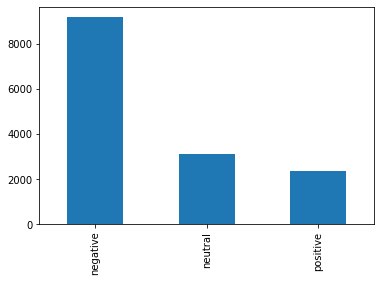

In [4]:
data['airline_sentiment'].value_counts().sort_index().plot.bar()

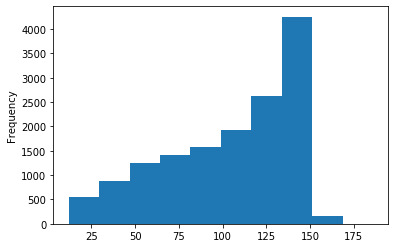

In [5]:
data['text'].str.len().plot.hist()

### Preprocessing

In [6]:
data['text'] = data['text'].str.replace('@VirginAmerica', '')
data.head()

,airline_sentiment,text
0,positive,"has getaway deals through May, from $59 one-w..."
1,positive,"@JetBlue Very excited, for the first time this..."
2,negative,@united is the worst. Worst reservation polici...
3,neutral,"@SouthwestAir Also, will Southwest have any ot..."
4,negative,your airline is awesome but your lax loft nee...


In [7]:
data['text'].apply(lambda x: x.lower()) #transform text to lowercase
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
data['text'].head()

0     has getaway deals through May from 59 oneway ...
1    JetBlue Very excited for the first time this S...
2    united is the worst Worst reservation policies...
3    SouthwestAir Also will Southwest have any othe...
4     your airline is awesome but your lax loft nee...
Name: text, dtype: object

In [8]:
tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(data['text'].values)

X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,   88, 2459, 1204,
         181,  481,   33, 2225, 2460,  862,   18,  509, 1371, 3098, 3099],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   17,
         149,  954,    7,    2,  150,   47,   29,  674,  955,  217,    3,
          30,    1,  103,   17,    8, 3670, 1313,   33,  221,  308,  604],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    5,   14,    2,  164,  164,  235, 1314,  164,
        1916,   42,  164,  164,  164, 1257,  311,  226,   24,   26,  206],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   16,  278,   49,  362,
          22,   93,  192, 4604,   94,    2,   74,   54,   35,  756,   39],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,   21,   

### Creating model

In [9]:
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 33, 256)           1280000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 33, 256)           525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [11]:
y = pd.get_dummies(data['airline_sentiment']).values
[print(data['airline_sentiment'][i], y[i]) for i in range(0,5)]

positive [0 0 1]
positive [0 0 1]
negative [1 0 0]
neutral [0 1 0]
negative [1 0 0]


[None, None, None, None, None]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Training model

In [13]:
batch_size = 32
epochs = 8

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

D:\Intalled Softwares\Anaconda\lib\site-packages\tensorflow\python\framework\indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/8
 - 146s - loss: 0.6526 - accuracy: 0.7287
Epoch 2/8
 - 140s - loss: 0.4521 - accuracy: 0.8214
Epoch 3/8
 - 181s - loss: 0.3690 - accuracy: 0.8636
Epoch 4/8
 - 215s - loss: 0.3112 - accuracy: 0.8834
Epoch 5/8
 - 98s - loss: 0.2652 - accuracy: 0.9006
Epoch 6/8
 - 100s - loss: 0.2226 - accuracy: 0.9186
Epoch 7/8
 - 98s - loss: 0.1966 - accuracy: 0.9286
Epoch 8/8
 - 99s - loss: 0.1647 - accuracy: 0.9397


In [17]:
model.save('sentiment_analysis.h5')

### Testing model

In [18]:
predictions = model.predict(X_test)

[print(data['text'][i], predictions[i], y_test[i]) for i in range(0, 5)]

 has getaway deals through May from 59 oneway Lots of cool cities httptcotZZJhuIbCH CheapFlights FareCompare [9.9947160e-01 4.8905285e-04 3.9294588e-05] [1 0 0]
JetBlue Very excited for the first time this Sunday March 1 I get to fly JetBlue flight 123 Mint from JFK Looking forward  [9.9942905e-01 3.9213878e-04 1.7881823e-04] [1 0 0]
united is the worst Worst reservation policies Worst costumer service Worst worst worst Congrats Delta youre not that bad [9.997657e-01 1.384334e-04 9.582337e-05] [1 0 0]
SouthwestAir Also will Southwest have any other specials like the one they are running now [9.9865985e-01 6.1672594e-04 7.2343845e-04] [1 0 0]
 your airline is awesome but your lax loft needs to step up its game 40 for dirty tables and floors httptcohy0VrfhjHt [0.06012113 0.9349834  0.00489549] [0 1 0]


[None, None, None, None, None]

In [19]:
pos_count, neu_count, neg_count = 0, 0, 0
real_pos, real_neu, real_neg = 0, 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==2:
        pos_count += 1
    elif np.argmax(prediction)==1:
        neu_count += 1
    else:
        neg_count += 1
    
    if np.argmax(y_test[i])==2:
        real_pos += 1
    elif np.argmax(y_test[i])==1:    
        real_neu += 1
    else:
        real_neg +=1

print('Positive predictions:', pos_count)
print('Neutral predictions:', neu_count)
print('Negative predictions:', neg_count)
print('Real positive:', real_pos)
print('Real neutral:', real_neu)
print('Real negative:', real_neg)

Positive predictions: 402
Neutral predictions: 619
Negative predictions: 1907
Real positive: 486
Real neutral: 616
Real negative: 1826


## Improvements we could implement
<ul>
    <li>Weight classes (because data is skew)</li>
    <li>Train more epochs</li>
    <li>Use bigger network</li>
    <li>Try other word number</li>
</ul>

## Resources

<ul>
    <li><a href="https://programmingwithgilbert.firebaseapp.com/videos/machine-learning-explained/recurrent-neural-networks-lstm-explained">Recurrent Neural Networks Explained (my own post and video)</a></li>
    <li><a href="https://en.wikipedia.org/wiki/Sentiment_analysis">Sentiment Analysis (Wikipedia)</a></li>
    <li><a href="https://www.quora.com/What-is-the-best-way-to-do-sentiment-analysis-with-Python-I%E2%80%99m-looking-for-a-sentiment-analysis-API-that-I-can-add-an-emoticon-dictionary-to-I-have-no-idea-how-to-use-NLTK-Can-anyone-help-me-with-that">What is the best way to do sentiment analysis with Python? (Quora)</a></li>
    <li><a href="https://www.youtube.com/watch?v=si8zZHkufRY">How to Do Sentiment Analysis (Siraj Raval)</a></li>
</ul>